In [846]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm.auto import tqdm
import random
import seaborn as sns

In [847]:
import copy


class Environment:

    def __init__(self, world_map):
        self.world_h = len(world_map)
        self.world_w = len(world_map[0])
        self.cargos = dict()
        self.desired_space = []
        # change r in world map to -1
        modified_world = []
        for row in world_map:
            modified_row = []
            for c in row:
                if c == 'r':
                    modified_row.append(-1)
                else:
                    modified_row.append(int(c))
            modified_world.append(modified_row)
        self.world = modified_world
        self.world = np.array(self.world)

        for i in range(len(world_map)):
            for j in range(len(world_map[0])):
                if world_map[i][j] == 'r':
                    self.desired_space.append((i, j))
                if world_map[i][j].isdigit() and int(world_map[i][j]) != 0:
                    if world_map[i][j] not in self.cargos:
                        self.cargos[world_map[i][j]] = []
                    self.cargos[world_map[i][j]].append((i, j))
        for key in self.cargos:
            self.cargos[key] = np.array(self.cargos[key])

        self.init_cargos = self.cargos.copy()
        self.init_desired_space = self.desired_space.copy()
        self.init_world = self.world.copy()

    def move_cargo(self, cargo, action):
        if action == 'D':
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == 'U':
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == 'R':
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == 'L':
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError('Action must be one of D, U, R, L')

        if np.any(new_pos < 0) or np.any(new_pos >= np.array([self.world_h, self.world_w])):
            raise ValueError('New position is out of bounds')
        self.world[self.cargos[cargo][:, 0], self.cargos[cargo][:, 1]] = 0
        self.world[new_pos[:, 0], new_pos[:, 1]] = int(cargo)
        self.cargos[cargo] = new_pos

    def check_move(self, cargo, action):
        if action == 'D':
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == 'U':
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == 'R':
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == 'L':
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError('Action must be one of D, U, R, L')

        if np.any(new_pos < 0) or np.any(new_pos >= np.array([self.world_h, self.world_w])):
            return False
        return True

    def world_visualisation(self):
        world = [[0 for _ in range(self.world_w)] for _ in range(self.world_h)]
        for key in self.cargos:
            for cargo_cell in self.cargos[key]:
                world[cargo_cell[0]][cargo_cell[1]] = key
        for space in self.desired_space:
            world[space[0]][space[1]] = 'r'
        return world

    def goal_distance(self, cargo):
        distances = []
        ids = []
        points = []
        for cargo_y, cargo_x in self.cargos[cargo]:
            min_y = 1e8
            min_x = 1e8
            id_y = -1
            id_x = -1
            min_cargo_point = (-1, -1)

            for des_y, des_x in self.desired_space:
                if abs(des_y - cargo_y) + abs(des_x - cargo_x) < min_y + min_x:
                    min_y = abs(des_y - cargo_y)
                    min_x = abs(des_x - cargo_x)
                    id_y = des_y
                    id_x = des_x
                    min_cargo_point = (cargo_y, cargo_x)
            distances.append(min_y + min_x)
            ids.append((id_y, id_x))
            points.append(min_cargo_point)
        min_id = np.argmax(distances)
        return distances[min_id], *ids[min_id], *points[min_id]

    def reset(self):
        self.cargos = self.init_cargos.copy()
        self.desired_space = self.init_desired_space.copy()
        self.world = self.init_world.copy()

    def get_cargo_overlaps(self):
        total_cells = []
        for cargo in self.cargos:
            for cell in self.cargos[cargo]:
                total_cells.append(cell)
        total_cells = np.array(total_cells)
        unique, counts = np.unique(total_cells, axis=0, return_counts=True)
        overlaped_cells = np.sum(counts > 1)
        return overlaped_cells

    def get_cargo_overlaps_with_desired(self):
        ret = 0
        for des_cell in self.desired_space:
            for cargo in self.cargos:
                for cargo_cell in self.cargos[cargo]:
                    if des_cell[0] == cargo_cell[0] and des_cell[1] == cargo_cell[1]:
                        ret += 1
        return ret

    def is_done(self):
        reward = 0
        reward -= self.get_cargo_overlaps()
        reward += self.get_cargo_overlaps_with_desired()
        cargo_cells = 0
        for cargo in self.cargos:
            cargo_cells += len(self.cargos[cargo])
        return reward == cargo_cells

    def copy(self):
        return copy.deepcopy(self)






In [848]:
#read from input file
file = open("input.txt", "r")
world_map = []
for line in file:
    line = line.strip()
    line = line.split()
    world_map.append(line)
file.close()
env = Environment(world_map)

In [849]:
n_world = env.world_visualisation()
for row in n_world:
    for cell in row:
        print(cell, end=' ')
    print()

1 0 0 0 0 0 0 
1 1 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 2 2 0 0 0 0 
0 0 0 0 0 r r 
0 0 0 0 0 r r 
0 0 0 0 0 r r 
0 0 0 0 0 r r 


In [850]:
class DQN(nn.Module):
    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [851]:
env.world

array([[ 1,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1]])

In [852]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [853]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_actions = 4

policy_net = DQN(n_actions)
target_net = DQN(n_actions)

In [854]:
memory = ReplayMemory(10000)
optimizer = optim.Adam(policy_net.parameters())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [855]:
env.world

array([[ 1,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1]])

In [856]:
env.move_cargo('1', "D")
env.cargos

{'1': array([[1, 0],
        [2, 0],
        [2, 1]]),
 '2': array([[4, 1],
        [4, 2]])}

In [857]:
env.reset()
env.cargos

{'1': array([[0, 0],
        [1, 0],
        [1, 1]]),
 '2': array([[4, 1],
        [4, 2]])}

In [858]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = np.random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # print("greedy")
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)

    else:
        # print("random")
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [859]:
def get_state(env):
    state = env.world
    state = np.array(state)
    state = state.reshape(1, 1, env.world_h, env.world_w)
    state = torch.from_numpy(state)
    state = state.float()
    return state


def get_reward(env, possible):
    reward = 0
    reward += env.get_cargo_overlaps_with_desired()
    reward -= env.get_cargo_overlaps()
    reward -= 1
    if not possible:
        reward = -100
    return torch.tensor([reward], dtype=torch.float)

In [860]:
actions_list = ['D', 'U', 'R', 'L']
MAX_STEPS = env.world_h * env.world_w
MAX_STEPS

63

In [861]:
total_train_rewards = []

def train(env, n_episodes=1000):
    for i_episode in range(n_episodes):
        env.reset()
        init_cargo_pos = env.cargos.copy()
        state = get_state(env)
        cargo_paths = []
        episode_rewards = []
        for cargo in env.cargos.keys():
            path = []
            cargo_total_reward = 0
            step = 0
            while True:
                step += 1
                if step > MAX_STEPS:
                    break
                action = select_action(state)
                is_possible_move = env.check_move(cargo, actions_list[action])
                path.append(actions_list[action])
                if is_possible_move:
                    env.move_cargo(cargo, actions_list[action])
                else:
                    pass

                reward = get_reward(env, is_possible_move)

                next_state = get_state(env)
                memory.push(state, action, next_state, reward)
                state = next_state
                optimize_model()
                cargo_total_reward += reward.item()

                cargo_paths.append(path)
                if env.is_done():
                    break
            episode_rewards.append(cargo_total_reward)

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("Episode: {}, Reward: {}".format(i_episode, episode_rewards))
        total_train_rewards.append(episode_rewards[0])
        print("Is done: {}".format(env.is_done()))
        print("Cargo positions: {}".format(env.cargos))
        print("Initial cargo positions: {}".format(init_cargo_pos))
        print(f'steps performed: {len(cargo_paths[0])}')
        print('-' * 40)

In [862]:
train(env)

Episode: 0, Reward: [-3235.0, -2241.0]
Is done: False
Cargo positions: {'1': array([[7, 0],
       [8, 0],
       [8, 1]]), '2': array([[6, 0],
       [6, 1]])}
Initial cargo positions: {'1': array([[0, 0],
       [1, 0],
       [1, 1]]), '2': array([[4, 1],
       [4, 2]])}
steps performed: 63
----------------------------------------
Episode: 1, Reward: [-1847.0, -365.0]
Is done: False
Cargo positions: {'1': array([[7, 2],
       [8, 2],
       [8, 3]]), '2': array([[1, 4],
       [1, 5]])}
Initial cargo positions: {'1': array([[0, 0],
       [1, 0],
       [1, 1]]), '2': array([[4, 1],
       [4, 2]])}
steps performed: 63
----------------------------------------
Episode: 2, Reward: [-2026.0, -539.0]
Is done: False
Cargo positions: {'1': array([[7, 2],
       [8, 2],
       [8, 3]]), '2': array([[5, 4],
       [5, 5]])}
Initial cargo positions: {'1': array([[0, 0],
       [1, 0],
       [1, 1]]), '2': array([[4, 1],
       [4, 2]])}
steps performed: 63
--------------------------------

KeyboardInterrupt: 

<AxesSubplot: >

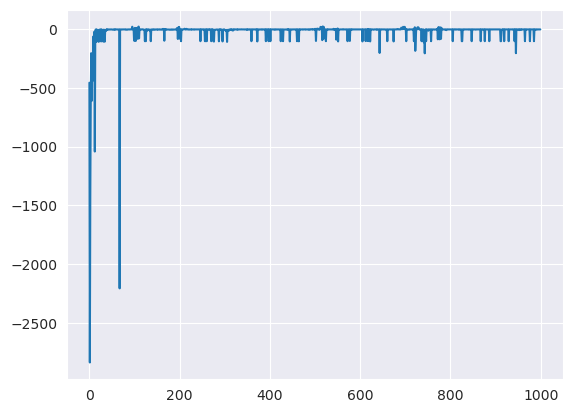

In [828]:
sns.lineplot(x=range(len(total_train_rewards)), y=total_train_rewards)